In [1]:
# import warnings
import rpy2
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from os import path, makedirs
from glob import glob
from statsmodels.stats.anova import AnovaRM
from rpy2.robjects.packages import importr
# import rpy2

    
from utils import formats, full_passed_turkers, DATA_DIR
from utils import read_cond_file, violation_analysis, get_attr, calc_SSRT, filter_ssrt_subs, get_p_str, ssrt_comparison
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
def get_go_shifts(data_df):
    data_df = data_df.copy()
    data_df = data_df.reset_index(drop=True)
    # fix up Trial Type col
    if 'SS' in data_df.columns:  # Matzke fix
        data_df['TrialType'] = data_df.SS
    data_df.TrialType = data_df.TrialType.str.lower()
    
    # get appropriate cols and condition keys
    if 'GoCriticalRT' in data_df.columns: 
        go_col = 'GoCriticalRT'
    elif 'Target.RT' in data_df.columns: #ADDED FOR MATZKE DATA
        go_col = 'Target.RT'
    else: 
        go_col = 'GoRT'
    
    # Matzke catch for stopFailRT column name
    stopFailRT_col = 'TargetDelay.RT' if 'TargetDelay.RT' in data_df.columns else 'StopFailureRT'
    # turk motor selec fix
    go_condition = 'gocritical' if 'gocritical' in data_df.TrialType.unique() else 'go'
    # check for Matzke data
    if 'Block' not in data_df.columns: data_df['Block'] = 1 #ADDED FOR MATZKE DATA - insert dummy block
    
    sub_out = {'meanGoRT': data_df[go_col].mean()}
    
    # Get Go and Stop Indices
    go_idx = data_df.query('TrialType=="%s"' % go_condition).index
    stop_idx = data_df.query('TrialType=="stop"').index
    stop_fail_idx = data_df.loc[data_df[stopFailRT_col] > 0].index
    assert all(x > 0 for x in data_df.loc[stop_fail_idx, stopFailRT_col].values)
    
    
    # getting goRTs that precede stop FAILURE trials
    # if first trial is a stop, ignore when looking at preceding trials
    tmp_stop_idx = stop_fail_idx[1:] if stop_fail_idx[0] == 0 else stop_fail_idx
    before_stop_df = data_df.loc[tmp_stop_idx-1, :]
    assert all(x in data_df.index for x in tmp_stop_idx-1)
    assert all(x in data_df.index for x in tmp_stop_idx)
    assert len(before_stop_df) == len(data_df.loc[tmp_stop_idx, 'Block'].values)
    before_stop_df['oldBlock'] = data_df.loc[tmp_stop_idx, 'Block'].values
    go_before_stop_df = before_stop_df.query('TrialType=="%s" and oldBlock==Block' % go_condition)
    sub_out['GoPrecedesStopFailRT'] = go_before_stop_df[go_col].mean()

    # getting goRTs that precede stop trials
    # if first trial is a stop, ignore when looking at preceding trials
    tmp_stop_idx = stop_idx[1:] if stop_idx[0] == 0 else stop_idx
    before_stop_df = data_df.loc[tmp_stop_idx-1, :]
    assert all(x in data_df.index for x in tmp_stop_idx-1)
    assert all(x in data_df.index for x in tmp_stop_idx)
    assert len(before_stop_df) == len(data_df.loc[tmp_stop_idx, 'Block'].values)
    before_stop_df['oldBlock'] = data_df.loc[tmp_stop_idx, 'Block'].values
    go_before_stop_df = before_stop_df.query('TrialType=="%s" and oldBlock==Block' % go_condition)
    sub_out['GoPrecedesStopRT'] = go_before_stop_df[go_col].mean()

    # getting goRTs that follow stop trials
    # if last trial is a stop, ignore when looking at following trials
    tmp_stop_idx = stop_idx[:-1] if stop_idx[-1]+1 == len(data_df) else stop_idx
    after_stop_df = data_df.loc[tmp_stop_idx+1, :]
    assert all(x in data_df.index for x in tmp_stop_idx+1)
    assert all(x in data_df.index for x in tmp_stop_idx)
    assert len(after_stop_df) == len(data_df.loc[tmp_stop_idx, 'Block'].values)
    after_stop_df['oldBlock'] = data_df.loc[tmp_stop_idx, 'Block'].values
    go_after_stop_df = after_stop_df.query('TrialType=="%s" and oldBlock==Block' % go_condition)
    sub_out['GoAfterStopRT'] = go_after_stop_df[go_col].mean()

    # getting goRTs that follow other go trials
    # if last trial is a go, ignore when looking at following trials
    tmp_go_idx = go_idx[:-1] if go_idx[-1]+1 == len(data_df) else go_idx
    after_go_df = data_df.loc[tmp_go_idx+1, :]
    assert all(x in data_df.index for x in tmp_go_idx+1)
    assert all(x in data_df.index for x in tmp_go_idx)
    assert len(after_go_df) == len(data_df.loc[tmp_go_idx, 'Block'].values)
    after_go_df['oldBlock'] = data_df.loc[tmp_go_idx, 'Block'].values
    go_after_go_df = after_go_df.query('TrialType=="%s" and oldBlock==Block' % go_condition)
    sub_out['GoAfterGoRT'] = go_after_go_df[go_col].mean()
    
    
    return sub_out

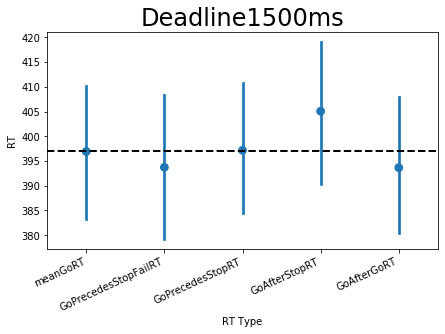

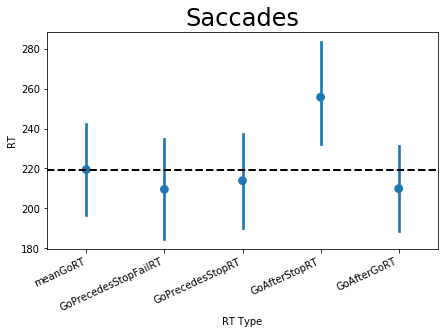

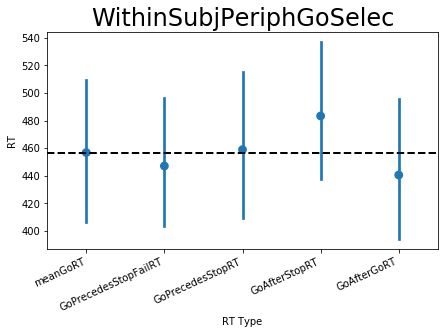

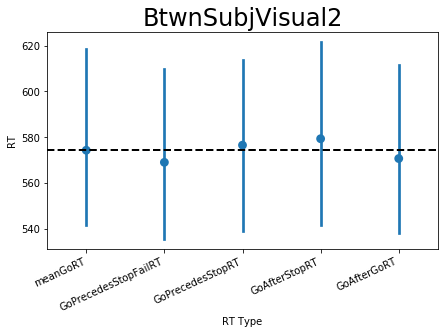

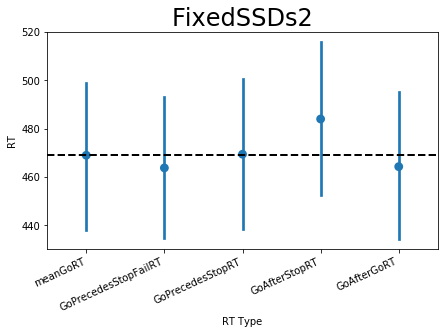

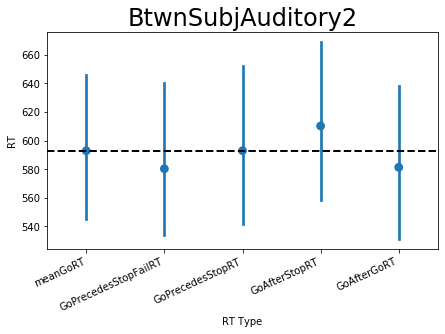

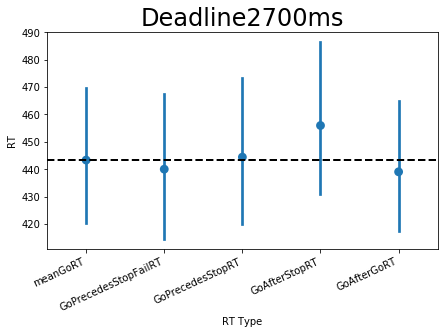

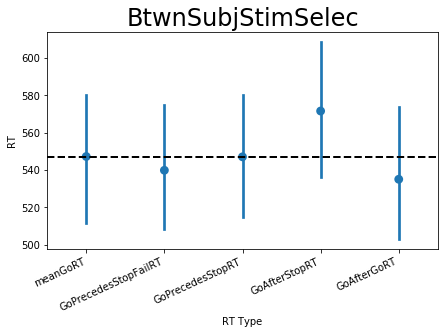

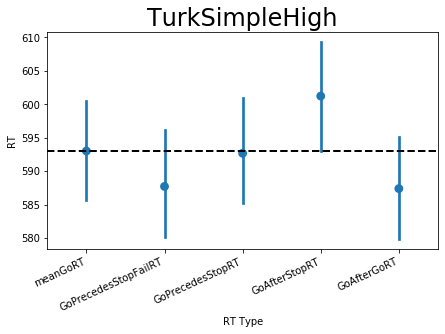

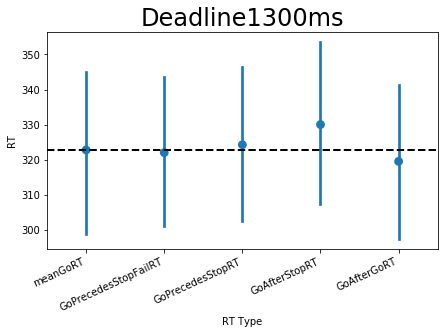

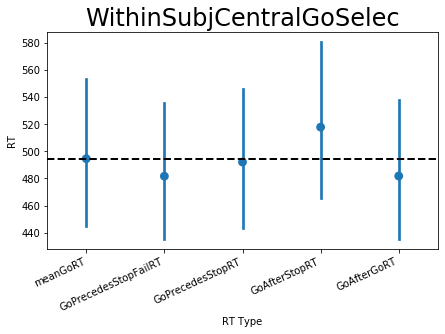

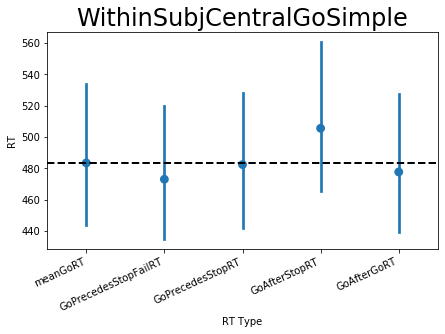

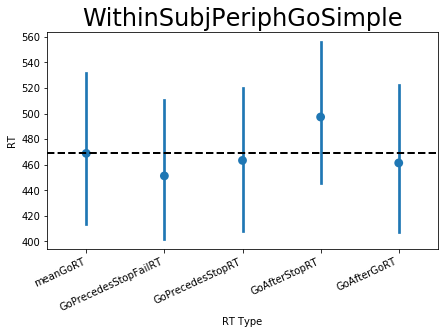

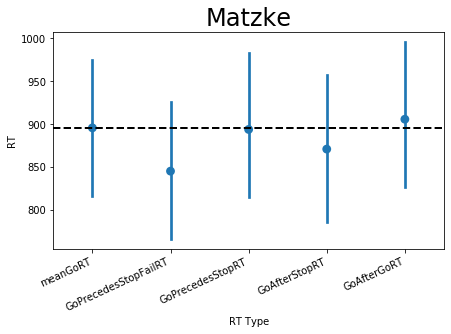

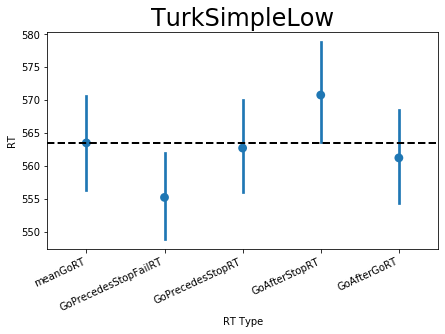

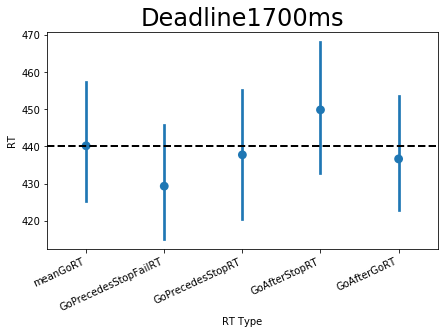

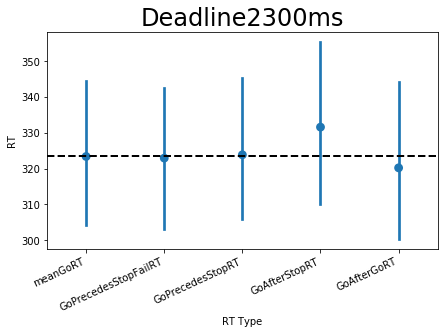

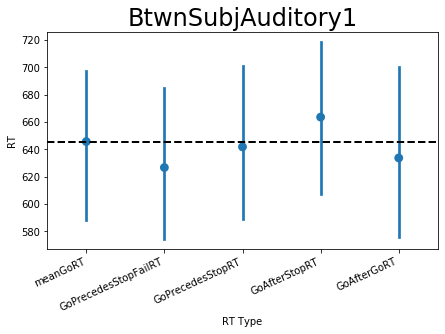

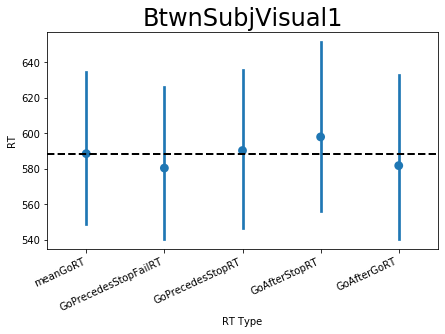

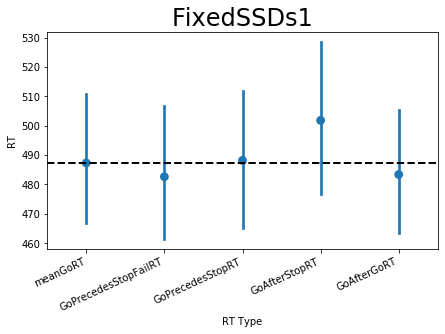

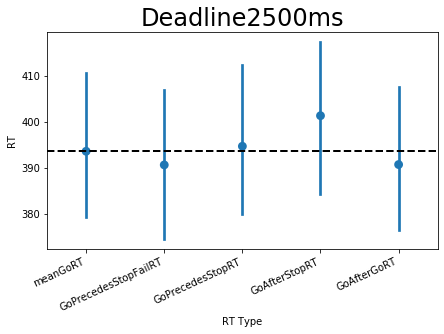

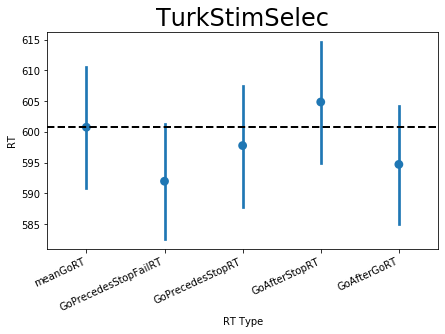

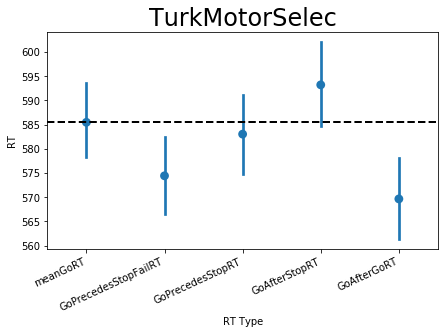

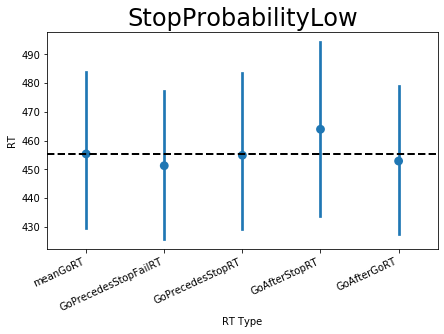

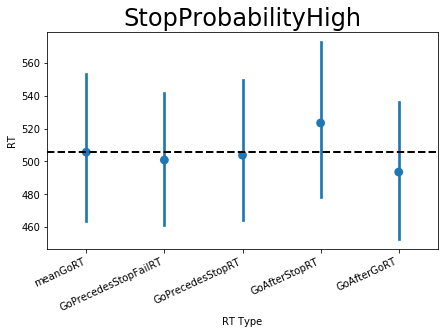

In [3]:
# get the various data files to analysis
condition_files = glob(path.join(DATA_DIR, 'Data*'))

full_melted_df = pd.DataFrame()

#for each data file, analyze and save the results
for condition_file in condition_files:
    condition_name = condition_file.replace('Data/Data', '').replace('.xlsx', '')
    curr_df = read_cond_file(condition_file)
    rt_out_df = curr_df.groupby('Subject').apply(get_go_shifts).apply(pd.Series)
    melted_df = rt_out_df.melt(value_vars=rt_out_df.columns, value_name='RT', var_name='RT Type')
    melted_df['condition'] = condition_name
    
    full_melted_df = pd.concat([full_melted_df, melted_df], 0)

    plt.figure(figsize=(7,4))
    ax = sns.pointplot(x='RT Type', y='RT', data=melted_df, join=False)
    ax.axhline(y=rt_out_df.meanGoRT.mean(), linewidth=2, linestyle='--', color='k')
    _ = ax.set_title(condition_name, fontsize=24)
    plt.xticks(rotation=25, ha='right')
    plt.show()
    plt.close()
    
    
#     # Makes prettier barplots, but harder to interperet
#     ax = sns.barplot(x='RT Type', y='RT', data=melted_df)
#     _ = ax.set_ylim(melted_df.RT.min()-.5*melted_df.RT.std(), ax.get_ylim()[-1])


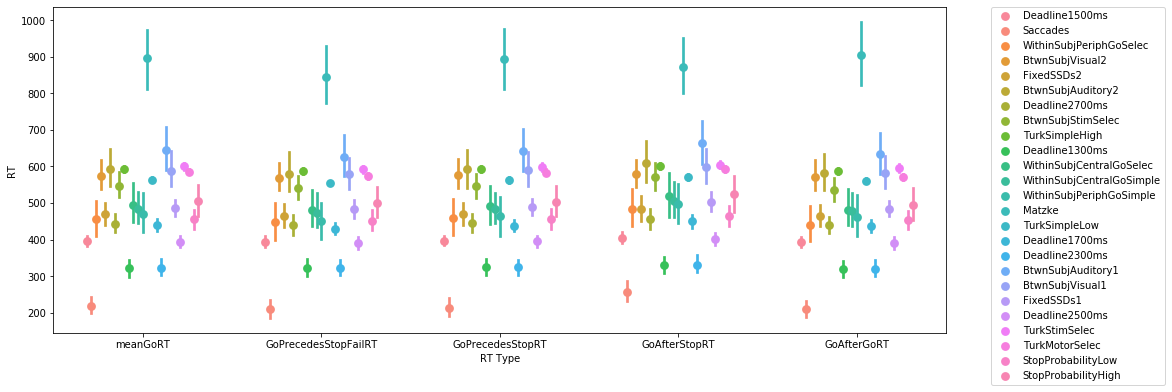

In [4]:
plt.figure(figsize=(16,6))
ax = sns.pointplot(x='RT Type', y='RT', hue='condition', data=full_melted_df, join=False, dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

## Meaning across all subs x conditions

In [5]:
full_melted_df.groupby('RT Type').mean()

,RT
RT Type,
GoAfterGoRT,564.732445
GoAfterStopRT,579.477296
GoPrecedesStopFailRT,562.666322
GoPrecedesStopRT,570.324585
meanGoRT,571.740663


## meaning within condition, then across conditions

In [6]:
full_melted_df.groupby(['condition', 'RT Type']).mean().groupby('RT Type').mean()

,RT
RT Type,
GoAfterGoRT,495.456393
GoAfterStopRT,514.822303
GoPrecedesStopFailRT,492.429299
GoPrecedesStopRT,501.115096
meanGoRT,501.912251
